In [5]:
import os

import numpy as np
import pandas as pd; pd.set_option('display.max_columns', None)
import warnings
warnings.simplefilter(action="ignore")

import matplotlib.pyplot as plt
plt.rcdefaults()
from matplotlib.gridspec import GridSpec
import seaborn as sns

from scipy.stats import pearsonr, spearmanr
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm

import utils

# Config
sns.set_context('notebook', font_scale=1.3)

## Functions

In [6]:
def plot_trajectory_hued_2reg(
    df,
    pat_id,
    pft = 'fvc',
    time_col="months_since_first_session",
    # group_column="is_proctored",
    ax=None,
):
    ### VARS
    figsize = (10, 5)
    colors = sns.color_palette("colorblind").as_hex()
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=figsize)
    
    # Primer scatter
    colors = {'fvc': colors[0], 'svc': colors[3]}
    vars   = {'fvc': 'fvcPercPred_2019', 'svc': 'vcPercPred'}
    
    # Proctored
    data_proc = df.query('subject_order == @pat_id and pftType == @pft and is_proctored == True')
    x1_plot = data_proc[time_col].values
    y1_plot = data_proc[vars[pft]].values
    ax.scatter(
            x1_plot,
            y1_plot,
            color=colors[pft],
            marker='o',
            linewidths =1,
            label='Proctored', #f'{pft.upper()} proc',
            s=55,
        )
    
    # Non proctored
    data_nonproc = df.query('subject_order == @pat_id and pftType == @pft and is_proctored == False')
    x2_plot = data_nonproc[time_col].values
    y2_plot = data_nonproc[vars[pft]].values
    ax.scatter(
            x2_plot,
            y2_plot,
            color=colors[pft],
            marker='o',
            linewidth=1,
            facecolors="none",
            label='Non-proctored',#f'{pft.upper()} non proc',
            s=55,
        )
      
    # Regressions
    # Proc
    (y_pred_proc, _, _, _, slope_proc, _, intercept_proc, _) = utils.fit_regression(x1_plot, y1_plot, output_all=True)
    x1_fit = np.append(x1_plot, 0)
    y_pred_proc = np.append(y_pred_proc, intercept_proc)

    ax.plot(
            x1_fit,
            y_pred_proc,
            color='black',
            linewidth=2,
            label=None,
        )
    
    # Non Proc
    (y_pred_non_proc, _, _, _, slope_non_proc, _, intercept_non_proc, _) = utils.fit_regression(x2_plot, y2_plot, output_all=True)
    x2_fit = np.append(x2_plot, 0)
    y_pred_non_proc = np.append(y_pred_non_proc, intercept_non_proc)

    ax.plot(
            x2_fit,
            y_pred_non_proc,
            color='black',
            linewidth=2,
            label=None,
        )
        
    ax.grid()

In [7]:
def plot_figure_supp2_supp4(
    data: pd.DataFrame,
    pat_list: list,
    #data_dict: list,
    pft: str = 'fvc',
    time_col="days_since_first_session",
    slopes_intercepts: pd.DataFrame = None, # el df con los slopes e intercepts para cada cond 
    **kwargs,
):
# FIXED VARS
    figsize=(16, 5)
    fs = 14
    label_y={'fvcPercPred_2019': 'FVC % predicted', 'vcPercPred': 'SVC % predicted'}
    xlabel='Months since enrollment'
    df = data.copy()
    ################
    n_cols = 6
    n_rows = 2
    
    # Creating the shared subplots (occupying the left half)
    fig = plt.figure(figsize=figsize, layout='constrained')
    gs = GridSpec(ncols=n_cols, nrows=n_rows, figure=fig, width_ratios=[1.5,1.5,1,1,1,1])
    
    # Create the subplots dynamically
    axs = [
            fig.add_subplot(gs[0, 0]), 
            fig.add_subplot(gs[0, 1]),
            fig.add_subplot(gs[1, 0]), 
            fig.add_subplot(gs[1, 1])
    ]
    ###############
    
    for i, pat in enumerate(pat_list):
        
        _ = plot_trajectory_hued_2reg(
            df,
            pat_id=pat,
            time_col=time_col,
            pft = pft,
            ax=axs[i])

        axs[i].set_xlim(0,16)
        axs[i].set_xticks([0,4,8,12,16])
        if i == 0 or i == 1:
            axs[i].set_xticklabels([])
            
        axs[i].set_ylim(0,150)
        axs[i].set_yticks([0,50,100,150])
        if i == 1 or i == 3:
            axs[i].set_yticklabels([])

        if i==1:
            axs[i].legend(loc='upper right')
            
        # add patient id
        pat = df[df['subject_order'] == pat]['subject_order'].values[0]
        axs[i].text(0.05, 0.05, pat, fontsize=fs, transform=axs[i].transAxes, ha='left', va='bottom')
    
    fig.text(.29, -.025, xlabel, ha='center', va='center', fontsize=20)
    fig.text(-.025, 0.5, 'FVC % predicted', ha='center', va='center', rotation='vertical', fontsize=20)
    #######################
    # Slopes
    single_ax = fig.add_subplot(gs[:, 2:4])
    col1 = 'slope_fvcPercPred_2019_proctored'
    col2 = 'slope_fvcPercPred_2019_unproctored'
        
    # Pasar a meses
    aux = slopes_intercepts[[col1, col2]].copy()
    # corr, p_val = pearsonr(aux[col1], aux[col2])
    corr, p_val = pearsonr(aux[col1], aux[col2])
    corr, p_val = round(corr,3), round(p_val,3)
    print(f'Pearson corr. slopes: {corr} (p-val: ({p_val}))\nN subjects: {(len(aux))}')
    
    corr, p_val = spearmanr(aux[col1], aux[col2])
    corr, p_val = round(corr,3), round(p_val,3)
    print(f'Spearman corr. slopes: {corr} (p-val: ({p_val}))\nN subjects: {(len(aux))}')
        
    single_ax.scatter(aux[col1], aux[col2], edgecolor='k', alpha=0.7, color='grey', cmap='viridis')
    single_ax.set_xlabel(f'Slope FVC % pred. / mo (proc)', fontsize=fs)
    single_ax.set_ylabel(f'Slope FVC % pred. / mo (non-proc)', fontsize=fs)
    
    # adjust the limits with data simetrically and a margin of 5 percent
    min_val = aux.min().min()
    max_val = aux.max().max()
    margin = 0.05
    min_val = min_val - abs(min_val * margin)
    max_val = max_val + abs(max_val * margin)
    lim = max(abs(min_val), abs(max_val))
    lim = 10.5
    single_ax.set_xlim(-lim-1, lim+1)    
    single_ax.set_ylim(-lim-1, lim+1)
    single_ax.set_xticks([-10,-5,0,5,10])
    single_ax.set_yticks([-10,-5,0,5,10])
    # single_ax.set_xlim(-lim, lim)    
    # single_ax.set_ylim(-lim, lim)
    
    single_ax.plot([-lim, lim], [-lim, lim], color='grey', linestyle='--', linewidth=2)
    single_ax.grid(True)
    
    #######################
    # Intercepts
    single_ax_2 = fig.add_subplot(gs[:, 4:6])
    col1 = 'intercept_fvcPercPred_2019_proctored'
    col2 = 'intercept_fvcPercPred_2019_unproctored'
    
    aux = slopes_intercepts[[col1, col2]].copy()
    corr, p_val = pearsonr(aux[col1], aux[col2])
    corr, p_val = round(corr,3), round(p_val,3)
    print(f'Pearson corr. intercepts: {corr} (p-val: ({p_val}))\nN subjects: {(len(aux))}')
    
    corr, p_val = spearmanr(aux[col1], aux[col2])
    corr, p_val = round(corr,3), round(p_val,3)
    print(f'Spearman corr. intercepts: {corr} (p-val: ({p_val}))\nN subjects: {(len(aux))}')
        
    single_ax_2.scatter(aux[col1], aux[col2], edgecolor='k', alpha=0.7, color='grey', cmap='viridis')
    single_ax_2.set_xlabel('Intercept FVC % pred. / mo (proc)', fontsize=fs)
    single_ax_2.set_ylabel('Intercept FVC % pred. / mo (non-proc)', fontsize=fs)

    # adjust the limits with data simetrically and a margin of 5 percent
    min_val = aux.min().min()
    max_val = aux.max().max()
    margin = 0.05
    min_val = min_val - abs(min_val * margin)
    max_val = max_val + abs(max_val * margin)
    min_val = 60
    max_val = 130

    # Plot identity line
    single_ax_2.plot([min_val, max_val], [min_val, max_val], color='grey', linestyle='--', linewidth=2)
    single_ax_2.grid(True)
    
    #######################
    # Format 
    # letters with automatic positioning
    axs[0].text(0.00, 1.35, 'a', fontsize=30, transform=axs[0].transAxes, va='top', ha='left')
    single_ax.text(0.00, 1.15, 'b', fontsize=30, transform=single_ax.transAxes, va='top', ha='left')
    single_ax_2.text(.00, 1.15, 'c', fontsize=30, transform=single_ax_2.transAxes, va='top', ha='left')
        
    # plt.show()
    return fig
    
    

## Data

In [8]:
PATH = 'data'
FILE = 'data_figsup2_sup4.csv'

df_data = pd.read_csv(os.path.join(PATH, FILE))
df_data = df_data.query('pftType=="fvc"')
print(df_data.shape)
df_data.head()

(265, 17)


,subject_order,session_id_hash,date_only,days_since_first_session,months_since_first_session,n_fvc_atleast_usable,pftType,fvcPercPred_2019,vcPercPred,is_proctored,coachedSessionID,slope_fvcPercPred_2019,intercept_fvcPercPred_2019,slope_vcPercPred,intercept_vcPercPred,y_pred_fvcPercPred_2019,y_pred_vcPercPred
286,pALS 31,d198f225e1ad61f6db090ff9a11697f4578bbab87f237e...,2023-03-08,29,0.966667,2,fvc,83.0,NaN,True,5d4e9175-226e-4860-a6f7-fe6a818e0706,-0.118429,85.762406,NaN,NaN,85.762406,NaN
287,pALS 31,fed0e8f99d12054066518cc1139315278e72c09d9a0b88...,2023-03-14,35,1.166667,4,fvc,89.0,NaN,True,e8bfbfc7-c256-40bd-8ec3-be617ddd0706,-0.118429,85.762406,NaN,NaN,85.051833,NaN
288,pALS 31,e5705d02b8cb67a9fa62407f28c35c2e95c755cc4a19ce...,2023-03-21,42,1.400000,3,fvc,90.0,NaN,True,6bd139a6-5ddb-4ffc-801b-7fa114b20706,-0.118429,85.762406,NaN,NaN,84.222831,NaN
289,pALS 31,24874555757aa344d0b9d6bbd389fac0e5e48d2d538c31...,2023-03-29,50,1.666667,4,fvc,80.0,NaN,True,82a99f2d-609f-4c83-baf5-a20b78460706,-0.118429,85.762406,NaN,NaN,83.275400,NaN
290,pALS 31,2a4c4538b8e4f09a63444b0f737fb1dc1c3319b274043f...,2023-04-04,56,1.866667,4,fvc,78.0,NaN,True,4ff5c203-c91d-45f7-8085-ce6cc5cb0706,-0.118429,85.762406,NaN,NaN,82.564827,NaN


In [9]:
# Calcular el df con los slopes e intercepts individuales
df_intercept_slopes = pd.DataFrame()
var = 'fvcPercPred_2019'
time_col = "months_since_first_session"
print(time_col)
tcol = time_col

for subj in df_data.subject_order.unique():
    df_proc = df_data.query('subject_order==@subj').query('is_proctored==True')
    df_nonproc = df_data.query('subject_order==@subj').query('is_proctored==False')
    
    # Proctored fit ols linear regression
    x = df_proc[tcol]
    y = df_proc[var]
    model = OLS(y, sm.add_constant(x)).fit()
    slope_proc, intercept_proc = model.params[tcol], model.params['const']
    
    # Non-proctored fit ols linear regression
    x = df_nonproc[tcol]
    y = df_nonproc[var]
    model = OLS(y, sm.add_constant(x)).fit()
    slope_nonproc, intercept_nonproc = model.params[tcol], model.params['const']
    
    df_intercept_slopes = df_intercept_slopes.append({
        'subject_order': subj,
        'intercept_fvcPercPred_2019_proctored': intercept_proc,
        'slope_fvcPercPred_2019_proctored': slope_proc,
        'intercept_fvcPercPred_2019_unproctored': intercept_nonproc,
        'slope_fvcPercPred_2019_unproctored': slope_nonproc
    }, ignore_index=True)

df_intercept_slopes.head(2)

months_since_first_session


,subject_order,intercept_fvcPercPred_2019_proctored,slope_fvcPercPred_2019_proctored,intercept_fvcPercPred_2019_unproctored,slope_fvcPercPred_2019_unproctored
0,pALS 31,91.561921,-4.976638,89.245152,-3.343572
1,pALS 7,109.563297,-0.888237,112.752663,-1.032945


## Figure

In [10]:
patient_sorted = [
    'pALS 5',  
    'pALS 31',
    'pALS 6', 
    'pALS 43',
]

In [11]:
df_intercept_slopes[['slope_fvcPercPred_2019_proctored', 'slope_fvcPercPred_2019_unproctored']].corr(method='pearson')

,slope_fvcPercPred_2019_proctored,slope_fvcPercPred_2019_unproctored
slope_fvcPercPred_2019_proctored,1.000000,0.890078
slope_fvcPercPred_2019_unproctored,0.890078,1.000000


Pearson corr. slopes: 0.89 (p-val: (0.0))
N subjects: 12
Spearman corr. slopes: 0.853 (p-val: (0.0))
N subjects: 12
Pearson corr. intercepts: 0.917 (p-val: (0.0))
N subjects: 12
Spearman corr. intercepts: 0.797 (p-val: (0.002))
N subjects: 12


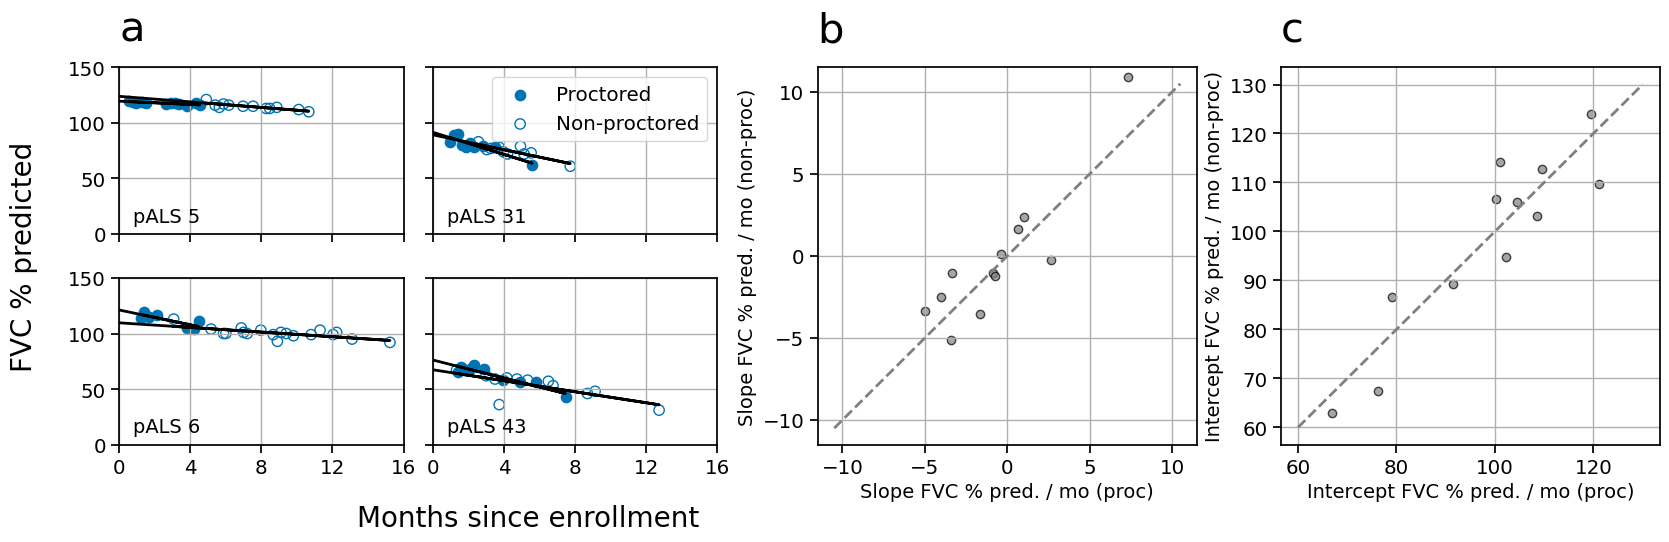

In [12]:
# Figura nueva
time_col = "months_since_first_session"
fig = plot_figure_supp2_supp4(
                    data = df_data, 
                    pat_list = patient_sorted,
                    slopes_intercepts=df_intercept_slopes,
                    time_col=time_col,
                )